# Code

## Get Data

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import threading
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1000, 2)
y shape: (1000,)


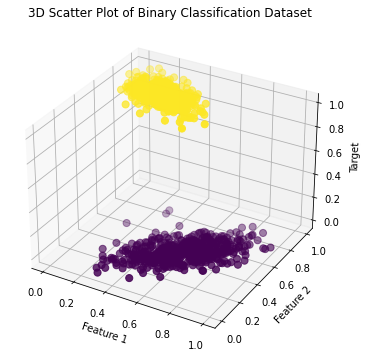

In [3]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

feature1 = X[:, 0]
feature2 = X[:, 1]
ax.scatter(feature1, feature2, y, c=y, cmap='viridis', s=50)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')

plt.title('3D Scatter Plot of Binary Classification Dataset')
plt.show()

## Classes

In [4]:
class Model(nn.Module):
    def __init__(self, input_shape):
        super(Model, self).__init__()
        self.input_shape = input_shape
        self.layer1 = nn.Linear(input_shape[0], 5, bias=True)
        self.layer2 = nn.Linear(5, 1, bias=True)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)

        return x

In [38]:
class Node():
    num_epochs = 10
    batch_size = 32
    lr = 0.005

    def __init__(self, model, X, y):
        self.model = model
        self.train_loader = self.preparData(X, y)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.gradient = None
        self.avg_loss = None

    def preparData(self, X, y):
        y = y.reshape((y.shape[0], 1))
        X = torch.tensor(X)
        y = torch.tensor(y)
        X = X.float()
        y = y.float()
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return data_loader

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0.0

            for inputs, targets in self.train_loader:
                self.optimizer.zero_grad()  
                outputs = self.model(inputs)  
                loss = self.criterion(outputs, targets)  
                loss.backward()  
                self.optimizer.step()

                total_loss += loss.item()

            self.avg_loss = total_loss / len(self.train_loader)
            ##print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {avg_loss}")
        
        self.gradient = [param.grad.clone() for param in self.model.parameters()]

In [51]:
class Central(Node):
    def __init__(self, num_workers, model, X, y):
        super(Central, self).__init__(model, X, y) #model is here
        self.num_workers = num_workers
        self.dataset = self.devideData(X, y)
        self.workers = [Node(model, self.dataset[0][i], self.dataset[1][i]) for i in range(num_workers)]
    
    def devideData(self, X, y):
        l_x = []
        l_y = []
        for i in range(self.num_workers):
            l_x.append(X[i* (X.shape[0]//self.num_workers): ((i+1) * (X.shape[0]//self.num_workers))])
            l_y.append(y[i* (X.shape[0]//self.num_workers): ((i+1) * (X.shape[0]//self.num_workers))])
        return l_x, l_y
    
    def agregate(self):
        grad = []
        for i in range(len(self.workers[0].gradient)):
            elem = 0
            for worker in self.workers:
                elem += worker.gradient[i]
            grad.append(elem)
        
        return grad
    
    def update(self):
        grad = self.agregate()

        with torch.no_grad():
            for param, gradient in zip(self.model.parameters(), grad):
                param -= self.lr * gradient
        
        total_loss = 0.0

        for inputs, targets in self.train_loader: 
            outputs = self.model(inputs)  
            loss = self.criterion(outputs, targets)  
            total_loss += loss.item()
            
        self.avg_loss = total_loss / len(self.train_loader)

In [52]:
model = Model(input_shape=(2,))

In [53]:
central = Central(3, model, X, y)

In [54]:
print(central.gradient)

None


In [55]:
for worker in central.workers:
    print(worker.gradient)

None
None
None


In [56]:
for worker in central.workers:
    worker.train()

In [57]:
for worker in central.workers:
    print(worker.avg_loss)

0.05904471332376653
0.04168528081341223
0.03885173966938799


In [58]:
print(central.avg_loss)

None


In [59]:
central.update()

In [60]:
central.avg_loss

0.040206277451943606